In [1]:
import numpy as np
from hybridReservoir import hybridESN
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import ode
from scipy.interpolate import UnivariateSpline

In [2]:
def perturbedlorenz(t, M, s, r, b, epsilon):
    x, y, z = M
    f = [s*(y - x), r*(1+epsilon)*x - y - x*z, x*y - b*z]
    return f

solver = ode(perturbedlorenz)
solver.set_integrator('dop853')
     
s=10
r=28
b=8/3.0
epsilon = 0.1
solver.set_f_params(s,r,b,epsilon)

t0 = 0.0
t1 = 400
N = 40000
M0 = [0., 1., 1.05]

t = np.linspace(t0, t1, N)


def hybridM(u):
    
    solver.set_initial_value(u, t0)

    solver.integrate(t[1])
        
    return solver.y



In [3]:
def lorenz(t, M, s, r, b):
    x, y, z = M
    f = [s*(y - x), r*x - y - x*z, x*y - b*z]
    return f

solver = ode(lorenz)
solver.set_integrator('dop853')

s = 10
r = 28
b = 8/3.0
solver.set_f_params(s,r,b)

t0 = 0.0
M0 = [0., 1., 1.05]
solver.set_initial_value(M0, t0)

t1 = 400
N = 40000
t = np.linspace(t0, t1, N)
sol = np.empty((N, 3))
sol[0] = M0

k = 1
while solver.successful() and solver.t < t1:
    solver.integrate(t[k])
    sol[k] = solver.y
    k += 1
    

In [4]:
"""
n_reservoir = 300, leak=0.75, noise = 0.001, bias=1,
          spectral_radius = 0.8,sparsity=0.5, fb_spectral_radius=0.8, fb_sparsity=0.5
"""
esn = hybridESN(n_outputs = 3, 
          n_reservoir = 600,
          # leak=0.8, noise = 0.001
          bias=1,
          spectral_radius = 0.7, sparsity=0.7,
          fb_spectral_radius = 0.8, fb_sparsity = 0.3
         )


In [5]:
trainlen = 30000 # timestep in the training
future = 10000 # timestep in the prediction
Lambda = 0.9056 
F = Lambda/100
tlist = np.array(range(0,future))*F #scale timestep
time = np.array(range(0,future))/100

In [6]:
pred_training = esn.fit(sol[:trainlen],hybridM)
prediction = esn.predict(future,hybridM)
print("test error: \n"+str(np.sqrt(np.mean((prediction - sol[trainlen:trainlen+future])**2))))

(30000, 600)
(30000, 3)
test error: 
11.967026505424082


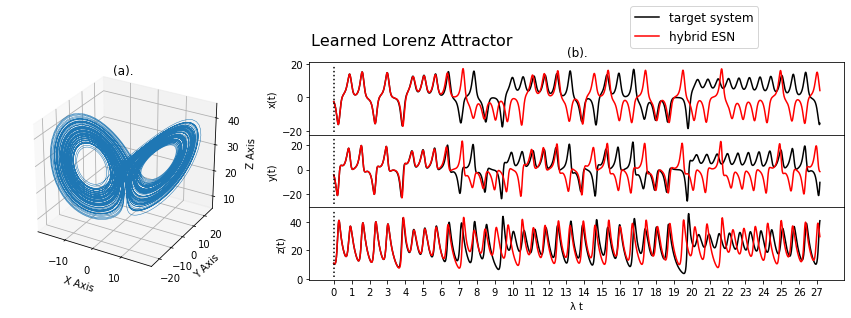

In [7]:
fig = plt.figure(constrained_layout=False)
gs = fig.add_gridspec(nrows=3, ncols=3,wspace=0.3,hspace=0.)

plta = fig.add_subplot(gs[:, 0],projection='3d')
plta.set_xlabel("X Axis")
plta.set_ylabel("Y Axis")
plta.set_zlabel("Z Axis")
plta.set_title("(a).")
plta.plot(prediction[:,0], prediction[:,1], prediction[:,2], lw=0.5)

pltb = fig.add_subplot(gs[0, 1:])
pltb.plot(tlist[0:3000],sol[trainlen:trainlen+3000,0],'k',label="target system")
pltb.plot(tlist[0:3000],prediction[0:3000,0],'r', label="hyrbid ESN")
lo,hi = pltb.get_ylim()
pltb.plot([tlist[0],tlist[0]],[lo+np.spacing(1),hi-np.spacing(1)],'k:')
pltb.set_ylabel("x(t)")
pltb.set_title("(b).")
plt.setp(pltb.get_xticklabels(), visible=False)


pltc = fig.add_subplot(gs[1, 1:], sharex=pltb)
pltc.plot(tlist[0:3000],sol[trainlen:trainlen+3000,1],'k',label="target system")
pltc.plot(tlist[0:3000],prediction[0:3000,1],'r', label="hybrid ESN")
lo1,hi1 = pltc.get_ylim()
pltc.plot([tlist[0],tlist[0]],[lo1+np.spacing(1),hi1-np.spacing(1)],'k:')
pltc.set_ylabel("y(t)")
plt.setp(pltc.get_xticklabels(), visible=False)


pltd = fig.add_subplot(gs[2, 1:], sharex=pltb)
pltd.plot(tlist[0:3000],sol[trainlen:trainlen+3000,2],'k',label="target system")
pltd.plot(tlist[0:3000],prediction[0:3000,2],'r', label="hybrid ESN")
lo2,hi2 = pltd.get_ylim()
pltd.plot([tlist[0],tlist[0]],[lo2+np.spacing(1),hi2-np.spacing(1)],'k:')
plt.xticks(range(28))
pltd.set_ylabel("z(t)")
pltd.set_xlabel("\u03BB t")


pltd.legend(loc=(0.6,3.2),fontsize='large')


fig.suptitle("Learned Lorenz Attractor", fontsize=16)
fig.set_size_inches(w=15,h=4)